**数据集：**
- Day 1-6: Train
- Day 7-10: Validation
- Day 11-13: Test

**预测目标：**
超短期预测（4h/15min）的风功率

In [2]:
# 数据集特征
n_back = 200
n_out = 16
n_pre = n_out*15*2
n_feature = 2

train_day = 6
validation_day = 4
test_day = 3

# 神经网络参数
units = [10, 20, 30, 40, 50]

# Preperation

In [3]:
from math import sqrt
import numpy as np
import pandas as pd

from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

2023-01-12 23:06:03.869707: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 23:06:04.085669: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 23:06:04.085701: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 23:06:05.247901: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [4]:
dataset = pd.read_csv('../../wind_preprocessed.csv', header=0, index_col=0).query('day<13')

In [5]:
data = dataset[['speed_moveavg', 'power_moveavg']].rename(columns={'power_moveavg':'power', 'speed_moveavg':'speed'})
print(data.head())

                       speed    power
date                                 
2015-10-01 00:00:00  0.39627  0.38065
2015-10-01 00:00:30  0.39592  0.36943
2015-10-01 00:01:00  0.39538  0.38529
2015-10-01 00:01:30  0.39579  0.38892
2015-10-01 00:02:00  0.39627  0.41220


In [6]:
values = data.values
values = values.astype('float32')

def series_to_supervised(data, n_in, n_out, colname, dropnan=True):
    n_vars = colname
    # n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out, 15*2):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j)) for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# 构建成监督学习问题
reframed = series_to_supervised(values, n_back, n_pre, ['speed', 'power'])
# 丢弃我们不想预测的列
for i in range(0, n_pre, 15*2):
    if i == 0:
        colname = 'speed(t)'
    else:
        colname = f'speed(t+{i})'
    reframed.drop(colname, axis=1, inplace=True)
# print(reframed.head(5))

In [7]:
# 分割为训练集和测试集
values = reframed.values
n_train = train_day*24*60*2
n_validation = validation_day*24*60*2
n_test = test_day*24*60*2
train = values[:n_train, :]
validation = values[n_train:n_train+n_validation, :]
test = values[-n_test:, :]
# 分为输入输出
n_obs = n_back * n_feature
train_X, train_y = train[:, :n_obs], train[:, -n_out:]
validation_X, validation_y = validation[:, :n_obs], validation[:, -n_out:]
test_X, test_y = test[:, :n_obs], test[:, -n_out:]
# 重塑成3D格式 [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_back, n_feature))
validation_X = validation_X.reshape((validation_X.shape[0], n_back, n_feature))
test_X = test_X.reshape((test_X.shape[0], n_back, n_feature))
print(train_X.shape, train_y.shape)
print(validation_X.shape, validation_y.shape)
print(test_X.shape, test_y.shape)

(17280, 200, 2) (17280, 16)
(11520, 200, 2) (11520, 16)
(8640, 200, 2) (8640, 16)


# Testing

In [8]:
import pickle
def plot_history(u, ax):
    with open(f'lstm_unit{u}_hist.pickle', 'rb') as f:
        history = pickle.load(f)
    ax.plot(history['loss'], label='validation', c='red')
    ax.plot(history['val_loss'], label='train', c='blue')
    ax.set_title(f'#Units={u}')
    ax.set_xlabel('Epcohs')
    ax.set_ylabel('Loss Function (RMSE)')
    plt.legend()

def predict(u):
    model = Sequential()
    model.add(LSTM(u, input_shape=(test_X.shape[1], test_X.shape[2])))
    model.add(Dense(n_out))
    model.load_weights(f"{u}.h5")
    yreal = model.predict(test_X, verbose=0)

def plot_rmse(yreal, i, ax, test_y=test_y):
    rmse = np.std(yreal - test_y, axis = i)
    acc = (np.ones_like(rmse) - rmse)*100
    print('RMSE:', np.mean(rmse))
    print('Accuracy', np.mean(acc))
    if i==0:
        print('Evaluate By Day')
        t = np.arange(0, len(rmse), 1)
        ax.scatter(t, rmse, color = 'r', label='RMSE')
        ax.plot(t, rmse,"-",color='r', linewidth=1)
        ax.set_ylabel('RMSE')
        ax.legend(loc=6, fontsize=8)
        if i==0:
            ax.set_xlabel('Time/15min')
        ax_twin = ax.twinx()
        ax_twin.scatter(t,acc, label='Accuracy')
        ax_twin.plot(t, acc,"-", linewidth=1)
        ax_twin.set_ylabel('Accuracy(%)')
        
        ax_twin.legend(loc=7, fontsize=8)

    else:
        print('Evaluate By Sample')
        print(np.where(rmse==min(rmse)))
        t = np.arange(0, len(rmse), 1)
        ax.scatter(t, rmse, color = 'r', s=5)
        ax.plot(t, rmse,"-",color='r', linewidth=1)
        plt.axhline(0.15, 0, len(rmse), linestyle='--', color='grey')
        ax.set_ylabel('RMSE', fontsize=12)
        ax.set_xlabel('Test Samples', fontsize=12)
        ax.set_ylim(0, 0.2)
        ax.set_yticks(np.arange(0, 0.2, 0.05))
        ax.text(0, 0.18, 'Mean RMSE={:.1f}%'.format(np.mean(rmse)*100), fontsize=12)
    


def test_one(ypre, i, ax):
    # 随机指定test_X中的一个sample看预测效果
    yhat_i = ypre[i]
    yreal_i = test_y.reshape((len(test_y), n_out))[i]
    # 计算RMSE
    rmse = sqrt(mean_squared_error(yreal_i, yhat_i))
    # # 计算平均相对误差
    # sigma = np.mean((yhat_i - yreal_i) / yreal_i * 100)
    # ax = fig.subplots(2, 1)[0]
    t = np.arange(1, 17, 1)/4
    ax.scatter(t, yhat_i, label='predict', s=10)
    ax.scatter(t, yreal_i, label='real', s=10)
    ax.legend()
    ax.set_ylabel('Power')
    ax.set_xlabel('Time/h')
    ax.set_xticks(np.arange(0, 17, 2)/4)
    ax.text(0.1, 0.325, 'RMSE={:.1f}%'.format(rmse*100))

    # ax1 = fig.subplots(2, 1)[1]
    # t = np.arange(0, len(yhat_i), 1)
    # ax1.scatter(t, yhat_i-yreal_i, s=10)
    # ax1.set_xlabel('Time/15min')
    # ax1.set_ylabel('Residuals')

    # x = np.arange(0, 1, 0.1)
    # plt.plot(x, x, color='C1')
    # plt.scatter(yreal_i, yhat_i, s=10)
    # # plt.plot(yreal, yreal, color='C1')
    # plt.xlabel('real')
    # plt.ylabel('predict')
    # plt.gca().set_aspect(1)
    # plt.xlim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
    # plt.ylim(min(min(yreal_i), min(yhat_i))-0.01, max(max(yreal_i), max(yhat_i))+0.01)
    # plt.text(min(min(yreal_i), min(yhat_i)), max(max(yreal_i), max(yhat_i)), 'RMSE={:.2f}, Sigma={:.2f}'.format(rmse, sigma))


In [9]:
ypres = []
for u in units:
    model = Sequential()
    model.add(LSTM(u, input_shape=(test_X.shape[1], test_X.shape[2])))
    model.add(Dense(n_out))
    model.load_weights(f"{u}.h5")
    ypre = model.predict(test_X, verbose=1)
    ypres.append(ypre)

2023-01-12 23:06:10.915339: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 23:06:10.917850: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 23:06:10.917952: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-VC833VJB): /proc/driver/nvidia/version does not exist
2023-01-12 23:06:10.920952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


270/270 [==============================] - 18s 66ms/step


RMSE: 0.17015311
Accuracy 82.98469
Evaluate By Day
RMSE: 0.17448078
Accuracy 82.551926
Evaluate By Day
RMSE: 0.17660208
Accuracy 82.3398
Evaluate By Day
RMSE: 0.17347163
Accuracy 82.65284
Evaluate By Day
RMSE: 0.17484564
Accuracy 82.515434
Evaluate By Day


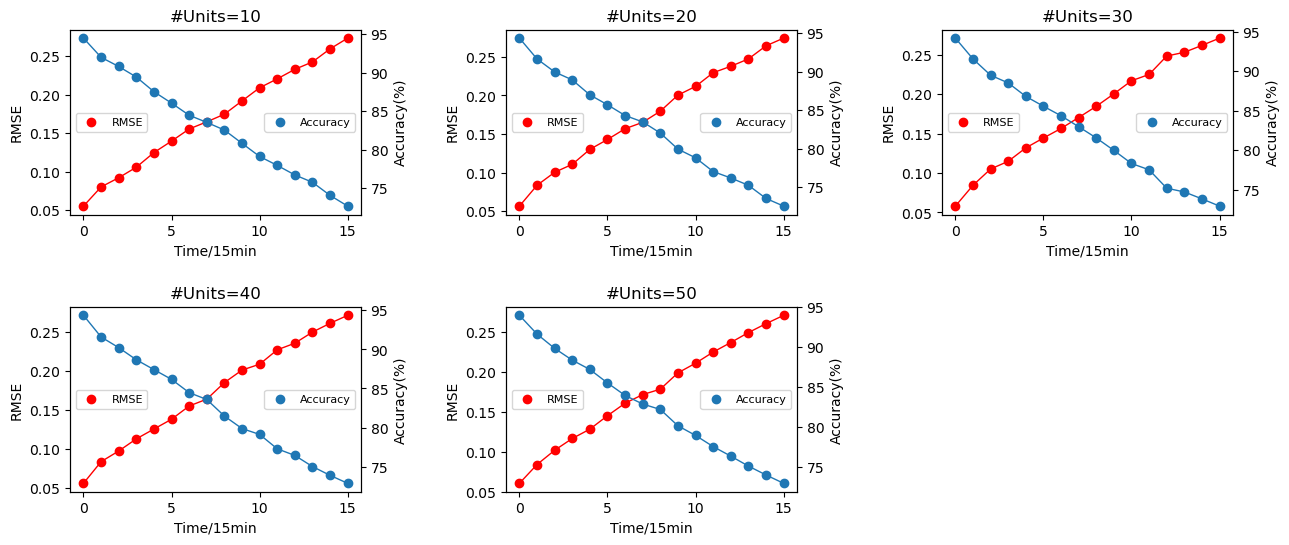

In [10]:
fig = plt.figure(figsize=(15, 6))
for i,y in enumerate(ypres):
    ax = fig.add_subplot(2, 3, i+1)
    plot_rmse(y, 0, ax)
    ax.set_title(f'#Units={units[i]}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

RMSE: 0.08778176
Accuracy 91.22183
Evaluate By Sample
(array([2886]),)
RMSE: 0.08718013
Accuracy 91.28198
Evaluate By Sample
(array([1816]),)
RMSE: 0.08641724
Accuracy 91.35828
Evaluate By Sample
(array([1857]),)
RMSE: 0.087427385
Accuracy 91.257256
Evaluate By Sample
(array([545]),)
RMSE: 0.08478138
Accuracy 91.52186
Evaluate By Sample
(array([1851]),)


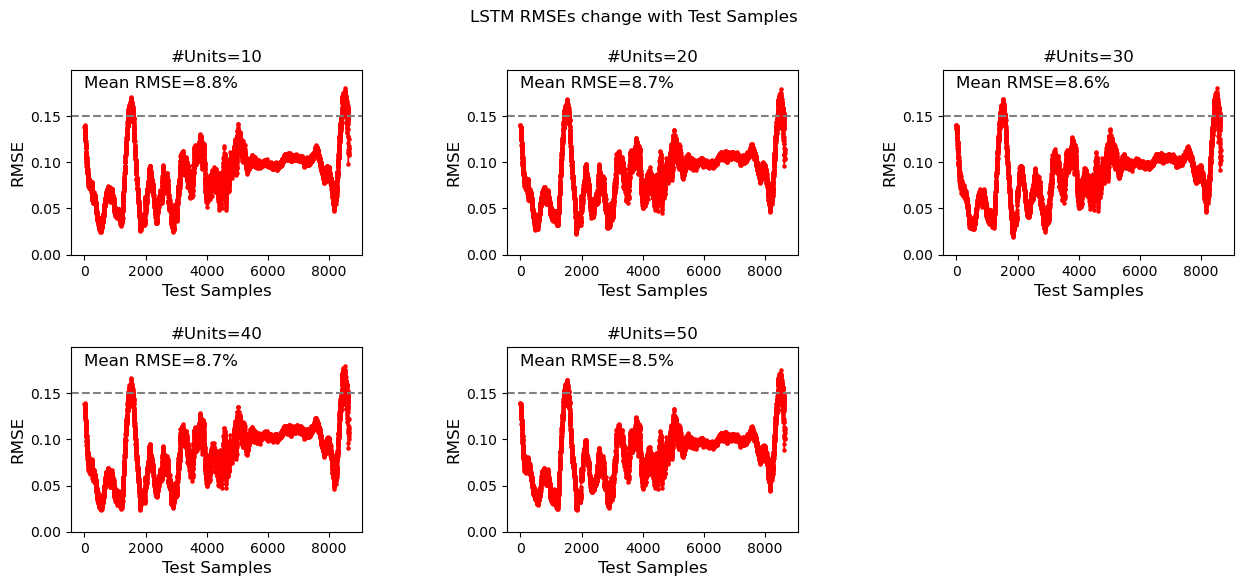

In [11]:
fig = plt.figure(figsize=(15, 6))
for i,y in enumerate(ypres):
    ax = fig.add_subplot(2, 3, i+1)
    plot_rmse(y, 1, ax)
    ax.set_title(f'#Units={units[i]}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('LSTM RMSEs change with Test Samples')
plt.show()

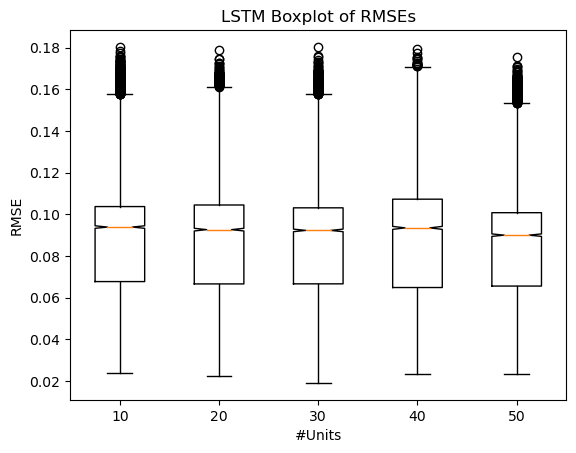

In [12]:
fig,ax = plt.subplots()
rmses = []
for i,y in enumerate(ypres):
    rmse = np.std(y - test_y, axis = 1)
    rmses.append(rmse)
ax.boxplot(rmses, notch=True)
ax.set_xlabel('#Units')
ax.set_ylabel('RMSE')
ax.set_title('LSTM Boxplot of RMSEs')
ax.set_xticklabels(["10", "20", "30", "40", "50"])
plt.show()

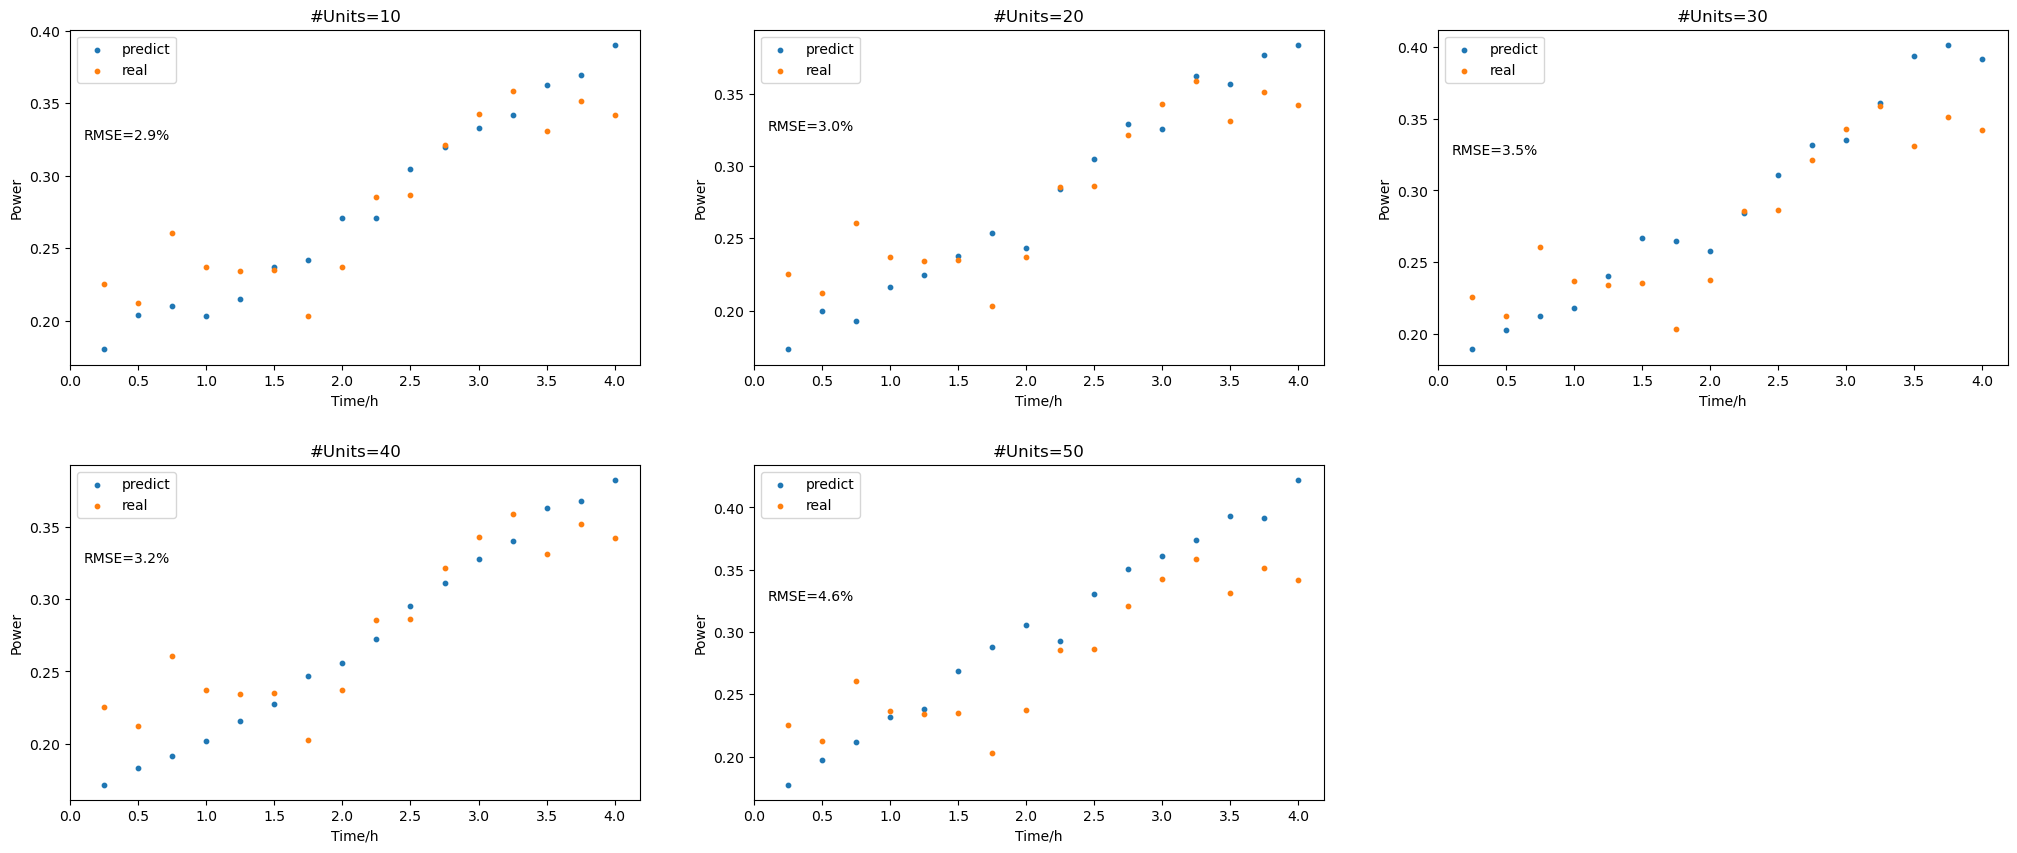

In [196]:
fig = plt.figure(figsize=(25, 10))
ind = 500
for i,y in enumerate(ypres):
    ax = fig.add_subplot(2, 3, i+1)
    test_one(y, ind, ax)
    ax.set_title(f'#Units={units[i]}')
plt.subplots_adjust(hspace=0.3)
plt.show()

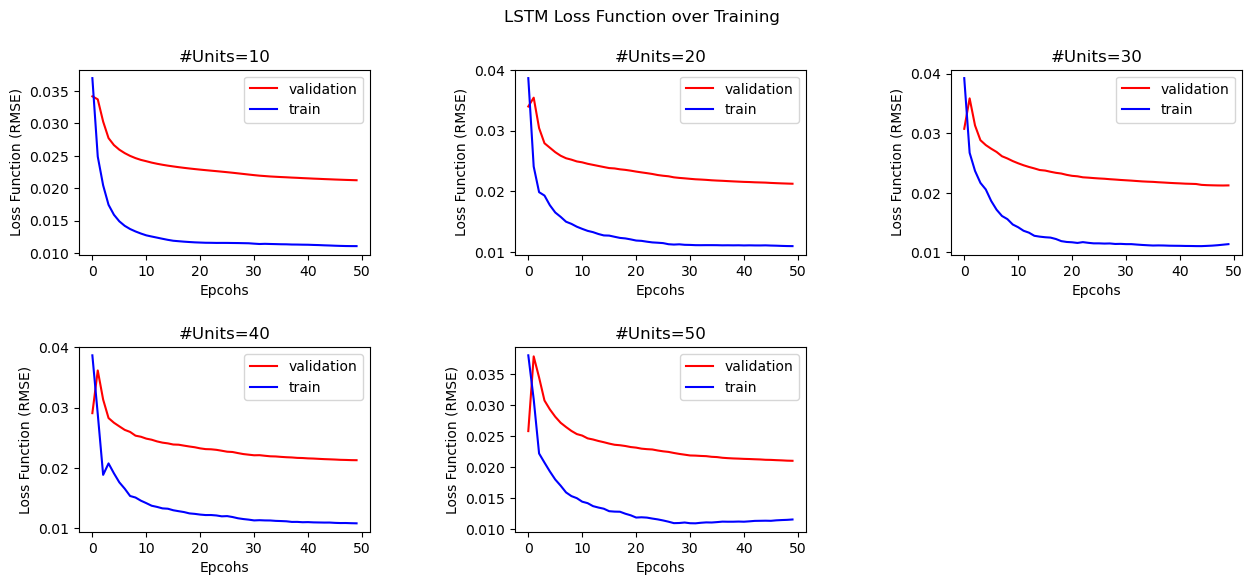

In [204]:
fig = plt.figure(figsize=(15, 6))
for i,u in enumerate(units):
    ax = fig.add_subplot(2, 3, i+1)
    plot_history(u, ax)

plt.subplots_adjust(hspace=0.5, wspace=0.5)
fig.suptitle('LSTM Loss Function over Training')
plt.show()